In [12]:
import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [13]:
class DatasetWrapper:
    def __init__(self, dataset, custom_mappings=None):
        self.dataset = dataset
        self.features = dataset.features if hasattr(dataset, 'features') else {}
        self.custom_mappings = custom_mappings or {}
        self.tag_names = self._get_tag_names()
    
    def _get_tag_names(self):
        for key in ['ner_tags', 'tags']:
            if key in self.custom_mappings:
                return self.custom_mappings[key]
            elif key in self.features:
                feature = self.features[key]
                if hasattr(feature, 'names'):
                    return feature.names
                elif hasattr(feature, 'feature'):
                    if hasattr(feature.feature, 'names'):
                        return feature.feature.names
                    elif hasattr(feature.feature, 'vocab'):
                        return {i: tag for i, tag in enumerate(feature.feature.vocab)}
        
        # If no mapping is found, try to infer from the first example
        first_example = next(iter(self.dataset), None)
        if first_example:
            for key in ['ner_tags', 'tags']:
                if key in first_example:
                    tags = first_example[key]
                    if isinstance(tags[0], int):
                        unique_tags = set(tags)
                        return {tag: str(tag) for tag in unique_tags}
                    elif isinstance(tags[0], str):
                        unique_tags = set(tags)
                        return {i: tag for i, tag in enumerate(unique_tags)}
        
        return None

    def int2str(self, tag_key):
        mapping = self.tag_names
        if mapping:
            return lambda x: mapping.get(x, str(x))
        else:
            return str


    def int2str(self, tag_key):
        mapping = self.tag_names
        if mapping:
            return lambda x: next((k for k, v in mapping.items() if v == x), str(x))
        else:
            return str

def bhattacharyya_coefficient(dist1, dist2):
    """Calculate Bhattacharyya coefficient between two distributions."""
    return sum((dist1.get(k, 0) * dist2.get(k, 0))**0.5 for k in set(dist1) | set(dist2))


def print_tag_distribution(name, tag_dist, tag_names=None):
    print(f"\n{name} Tag Distribution:")
    for tag, freq in sorted(tag_dist.items(), key=lambda x: x[1], reverse=True)[:20]:  # Top 20 tags
        tag_name = next((k for k, v in tag_names.items() if v == tag), str(tag)) if tag_names else str(tag)
        print(f"{tag_name}: {freq:.4f}")

def get_tag_distribution(dataset, tag_key='ner_tags'):
    """Get the distribution of tags in the dataset."""
    all_tags = []
    int2str = dataset.int2str(tag_key)
    
    for example in dataset.dataset:
        tags = example.get(tag_key)
        if tags is None:
            tags = example.get('tags')  # Try 'tags' if 'ner_tags' not found
        
        if tags is None:
            print(f"Warning: Neither '{tag_key}' nor 'tags' found in example. Skipping.")
            continue
        
        if isinstance(tags, list) and len(tags) > 0:
            if isinstance(tags[0], int):
                all_tags.extend([int2str(tag) for tag in tags])
            else:
                all_tags.extend(tags)
        else:
            print(f"Warning: Unexpected format for tags. Expected non-empty list.")
    
    if not all_tags:
        print(f"No valid tags found for key '{tag_key}' or 'tags' in the dataset.")
        return {}
    
    tag_counts = Counter(all_tags)
    total = sum(tag_counts.values())
    return {tag: count / total for tag, count in tag_counts.items()}

def get_word_distribution(dataset, token_key='tokens'):
    """Get the word distribution in the dataset."""
    all_words = [word for example in dataset.dataset for word in example.get(token_key, [])]
    word_counts = Counter(all_words)
    total = sum(word_counts.values())
    return {word: count / total for word, count in word_counts.items()}



def get_top_words_for_tags_old(dataset, tag_key, token_key, top_n=5):
    """Get top words for each tag."""
    tag_word_counts = {}
    for example in dataset.dataset:
        tags = example.get(tag_key) or example.get('tags', [])
        words = example.get(token_key, [])
        for tag, word in zip(tags, words):
            if tag not in tag_word_counts:
                tag_word_counts[tag] = Counter()
            tag_word_counts[tag][word] += 1
    
    return {tag: dict(counts.most_common(top_n)) for tag, counts in tag_word_counts.items()}

def get_top_words_for_tags(dataset, tag_key, token_key, top_n=5):
    tag_word_counts = {}
    int2str = dataset.int2str(tag_key)
    for example in dataset.dataset:
        tags = example.get(tag_key) or example.get('tags', [])
        words = example.get(token_key, [])
        for tag, word in zip(tags, words):
            tag_name = int2str(tag)
            if tag_name not in tag_word_counts:
                tag_word_counts[tag_name] = Counter()
            tag_word_counts[tag_name][word] += 1
    
    return {tag: dict(counts.most_common(top_n)) for tag, counts in tag_word_counts.items()}

def plot_tag_distribution(tag_dist, title):
    """Plot the tag distribution."""
    tags, frequencies = zip(*sorted(tag_dist.items(), key=lambda x: x[1], reverse=True)[:20])  # Top 20 tags
    plt.figure(figsize=(12, 6))
    plt.bar(tags, frequencies)
    plt.title(title)
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [14]:
ontonotes_dataset = load_dataset("tner/ontonotes5", trust_remote_code=True, split="train")
bc5cdr_dataset = load_dataset("tner/bc5cdr", trust_remote_code=True, split="train")
conll_dataset = load_dataset("tner/conll2003", trust_remote_code=True, split="train")

In [15]:
for feature in ontonotes_dataset.features:
    print(f"  - {feature}")
    

  - tokens
  - tags


In [16]:
conll_dataset[0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'tags': [1, 0, 2, 0, 0, 0, 2, 0, 0]}

In [17]:
ontonotes_ner_mapping = {"O": 0, "B-CARDINAL": 1, "B-DATE": 2, "I-DATE": 3, "B-PERSON": 4, "I-PERSON": 5, "B-NORP": 6, "B-GPE": 7, "I-GPE": 8, "B-LAW": 9, "I-LAW": 10, "B-ORG": 11, "I-ORG": 12, "B-PERCENT": 13, "I-PERCENT": 14, "B-ORDINAL": 15, "B-MONEY": 16, "I-MONEY": 17, "B-WORK_OF_ART": 18, "I-WORK_OF_ART": 19, "B-FAC": 20, "B-TIME": 21, "I-CARDINAL": 22, "B-LOC": 23, "B-QUANTITY": 24, "I-QUANTITY": 25, "I-NORP": 26, "I-LOC": 27, "B-PRODUCT": 28, "I-TIME": 29, "B-EVENT": 30, "I-EVENT": 31, "I-FAC": 32, "B-LANGUAGE": 33, "I-PRODUCT": 34, "I-ORDINAL": 35, "I-LANGUAGE": 36}
bc5cdr_mapping = {"O": 0, "B-Chemical": 1, "B-Disease": 2, "I-Disease": 3, "I-Chemical": 4}

In [18]:
conll_mapping = {
  "O": 0,
  "B-ORG": 1,
  "B-MISC": 2,
  "B-PER": 3,
  "I-PER": 4,
  "B-LOC": 5,
  "I-ORG": 6,
  "I-MISC": 7,
  "I-LOC": 8
}


In [19]:
custom_mappings = {
    'ontonotes': {'tags': ontonotes_ner_mapping},
    'bc5cdr': {'tags': bc5cdr_mapping},
    'conll_dataset' : {'tags':conll_mapping}
}

In [20]:

datasets = {
    'OntoNotes5': (ontonotes_dataset, 'tags', 'tokens', ontonotes_ner_mapping),
    'bc5cdr': (bc5cdr_dataset, 'tags', 'tokens', bc5cdr_mapping),
    'CoNLL-2003': (conll_dataset, 'tags', 'tokens', conll_mapping)
    # Add more datasets as needed
}

tag_distributions = {}
word_distributions = {}

for name, (dataset, tag_key, token_key, label_mapping) in datasets.items():
    wrapped_dataset = DatasetWrapper(dataset, custom_mappings.get(name))
    tag_distributions[name] = get_tag_distribution(wrapped_dataset, tag_key)
    word_distributions[name] = get_word_distribution(wrapped_dataset, token_key)

# Calculate Bhattacharyya coefficients
dataset_names = list(datasets.keys())

# Initialize a matrix to store coefficients
num_datasets = len(dataset_names)
coefficient_matrix_words = np.zeros((num_datasets, num_datasets))

coefficient_matrix_tags = np.zeros((num_datasets, num_datasets))

for i in range(len(dataset_names)):
    for j in range(i+1, len(dataset_names)):
        name1, name2 = dataset_names[i], dataset_names[j]
        
        # Align tag distributions
        all_tags = set(tag_distributions[name1].keys()) | set(tag_distributions[name2].keys())
        aligned_dist1 = np.array([tag_distributions[name1].get(tag, 0) for tag in all_tags])
        aligned_dist2 = np.array([tag_distributions[name2].get(tag, 0) for tag in all_tags])
        
        tag_bc = bhattacharyya_coefficient(tag_distributions[name1], tag_distributions[name2])
        
        # For word distributions, use the top N most common words
        top_n = 1000  # You can adjust this number
        words1 = set(dict(Counter(word_distributions[name1]).most_common(top_n)).keys())
        words2 = set(dict(Counter(word_distributions[name2]).most_common(top_n)).keys())
        
        all_words = words1 | words2

        aligned_word_dist1 = np.array([word_distributions[name1].get(word, 0) for word in all_words])
        aligned_word_dist2 = np.array([word_distributions[name2].get(word, 0) for word in all_words])
        
        word_bc = bhattacharyya_coefficient(dict(zip(all_words, aligned_word_dist1)), 
                                            dict(zip(all_words, aligned_word_dist2)))
        

        coefficient_matrix_tags[i, j] = tag_bc 
        coefficient_matrix_tags[j, i] = tag_bc 
        
        # Store coefficients in the matrix
        coefficient_matrix_words[i, j] = word_bc
        coefficient_matrix_words[j, i] = word_bc  # Matrix is symmetric
        
        print(f"Bhattacharyya coefficient between {name1} and {name2}:")
        print(f"  NER tag distributions: {tag_bc:.4f}")
        print(f"  Word distributions: {word_bc:.4f}")

# Set diagonal to 1 (each dataset is identical to itself)
np.fill_diagonal(coefficient_matrix_words, 1)
np.fill_diagonal(coefficient_matrix_tags, 1)





Bhattacharyya coefficient between OntoNotes5 and bc5cdr:
  NER tag distributions: 0.0000
  Word distributions: 0.5212
Bhattacharyya coefficient between OntoNotes5 and CoNLL-2003:
  NER tag distributions: 0.9559
  Word distributions: 0.6158
Bhattacharyya coefficient between bc5cdr and CoNLL-2003:
  NER tag distributions: 0.0000
  Word distributions: 0.4895


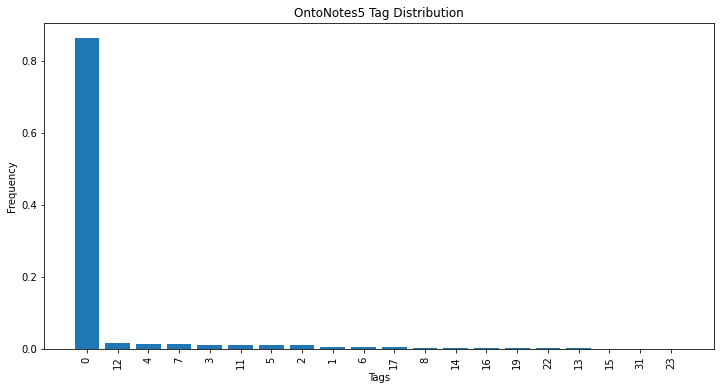

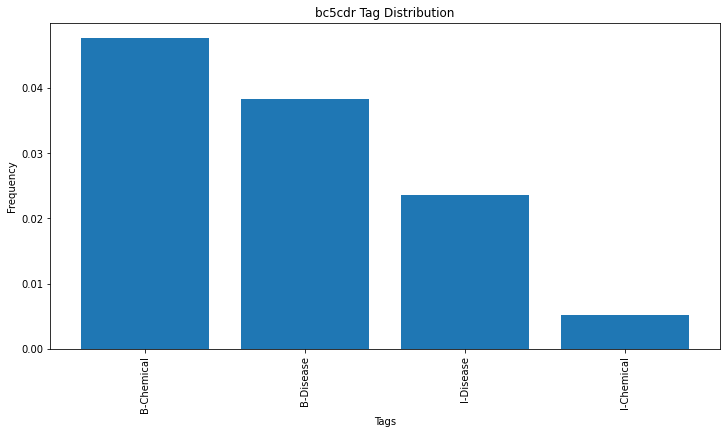

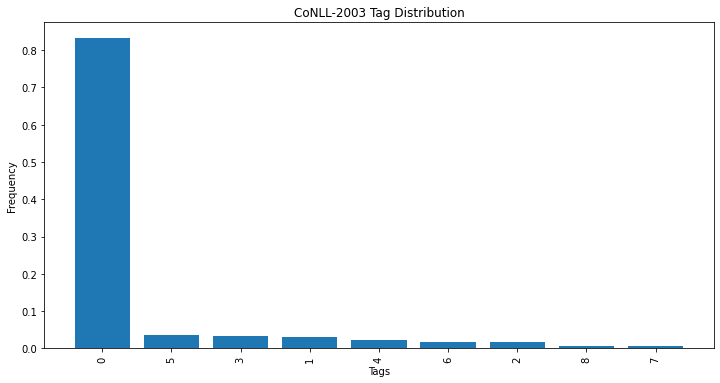

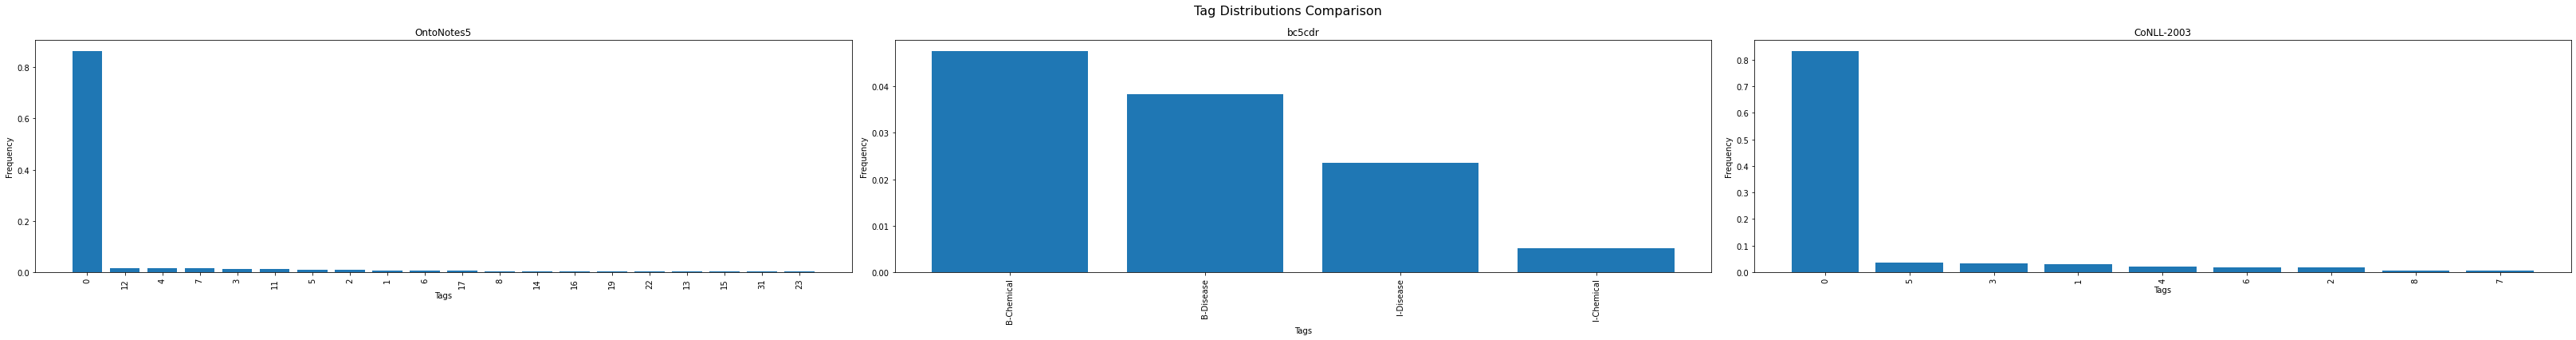

In [21]:
import matplotlib.pyplot as plt

def plot_tag_distribution(tag_dist, title, exclude_tags=None, ax=None):
    """Plot the tag distribution."""
    if exclude_tags is None:
        exclude_tags = set()
    
    # Filter out excluded tags and sort
    filtered_dist = {tag: freq for tag, freq in tag_dist.items() if tag not in exclude_tags}
    tags, frequencies = zip(*sorted(filtered_dist.items(), key=lambda x: x[1], reverse=True)[:20])  # Top 20 tags
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.bar(tags, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Tags')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)
    
    return ax

def plot_multiple_tag_distributions(tag_distributions, titles, exclude_tags=None):
    """Plot multiple tag distributions side by side."""
    num_plots = len(tag_distributions)
    fig, axes = plt.subplots(1, num_plots, figsize=(15*num_plots, 6), squeeze=False)
    fig.suptitle("Tag Distributions Comparison", fontsize=16)
    
    for i, (tag_dist, title) in enumerate(zip(tag_distributions, titles)):
        plot_tag_distribution(tag_dist, title, exclude_tags, axes[0, i])
    
    plt.tight_layout()
    plt.show()

# Usage in main script:
exclude_tags = {'O'}  # Add any tags you want to exclude here

# For individual plots
for name, tag_dist in tag_distributions.items():
    plot_tag_distribution(tag_dist, f"{name} Tag Distribution", exclude_tags)

# For side-by-side comparison
plot_multiple_tag_distributions(
    list(tag_distributions.values()),
    list(tag_distributions.keys()),
    exclude_tags
)

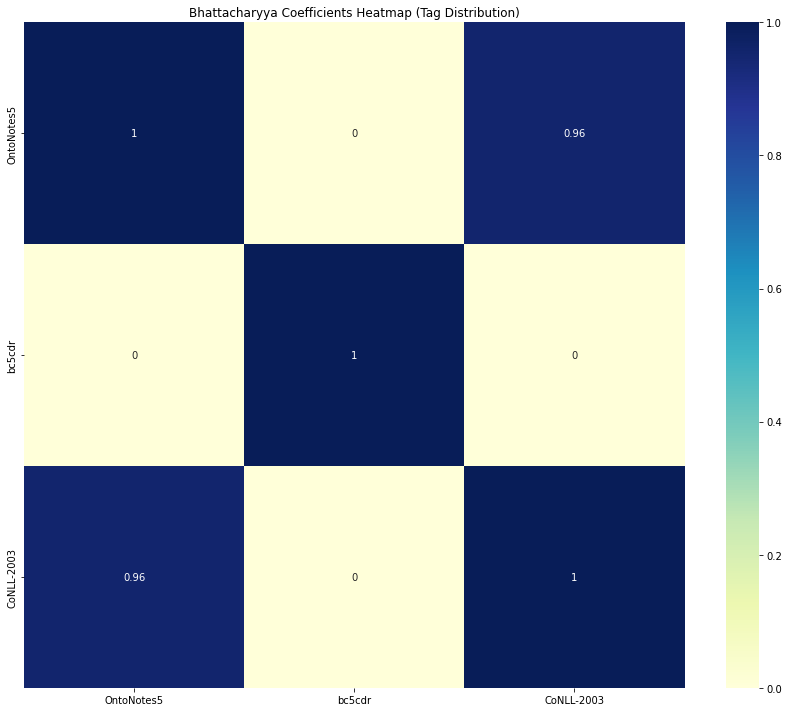

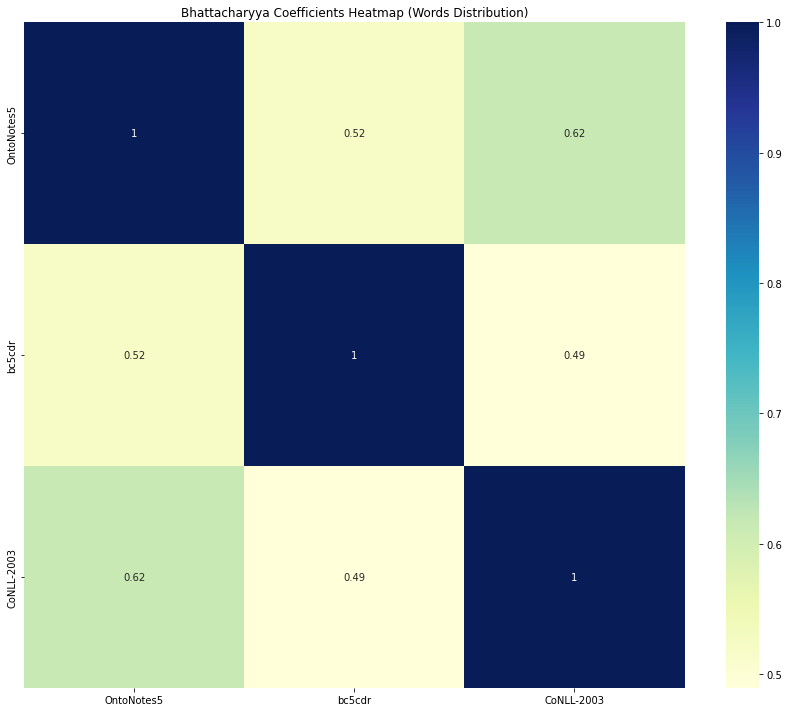

In [22]:
# Create heatmap
def plot_heatmap(coefficient_matrix, dataset_names, title = None):
    plt.figure(figsize=(12, 10))
    sns.heatmap(coefficient_matrix, annot=True, cmap='YlGnBu', xticklabels=dataset_names, yticklabels=dataset_names)
    plt.title(f'Bhattacharyya Coefficients Heatmap ({title})')
    plt.tight_layout()
    plt.show()


plot_heatmap(coefficient_matrix_tags, dataset_names, 'Tag Distribution')
plot_heatmap(coefficient_matrix_words, dataset_names, 'Words Distribution')
